In [1]:
import numpy as np
import trfp
import scipy.optimize
import matplotlib.pyplot as plt
from numpy import sqrt

In [2]:
def __multipole(order, skew, strength, x_pos, y_pos):
    """Returns the magnitude of a B-field given multipole parameters
    and position.
    """
    # Takes a multipole strength A normalized to 4.5 cm
    r_pos = np.sqrt(x_pos**2 + y_pos**2)
    theta = np.arctan2(y_pos, x_pos)
    if skew == 0:
        b_magnitude = strength * (r_pos/4.5)**order * np.cos(order*theta)
    if skew == 1:
        b_magnitude = strength * (r_pos/4.5)**order * np.sin(order*theta)
    return b_magnitude

## Legendre polynomial moments
legendre_coeffs = np.array([[1./2., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # const
                            [0, sqrt(3)/2., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # x
                            [0, 0, sqrt(3)/2., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # y
                            [sqrt(5)/-4., 0, 0, sqrt(5)*3./4., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # x^2
                            [0, 0, 0, 0, 3./2., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  #xy
                            [sqrt(5)/-4., 0, 0, 0, 0, sqrt(5)*3./4., 0, 0, 0, 0, 0, 0, 0, 0, 0],  # y^2
                            [0, sqrt(7)*-3./4., 0, 0, 0, 0, sqrt(7)*5./4., 0, 0, 0, 0, 0, 0, 0, 0],  # x^3
                            [0, 0, sqrt(15)*-1./4., 0, 0, 0, 0, sqrt(15)*3./4., 0, 0, 0, 0, 0, 0, 0],  #x^2 y
                            [0, sqrt(15)*-1./4., 0, 0, 0, 0, 0, 0, sqrt(15)*3./4., 0, 0, 0, 0, 0, 0], # x y^2
                            [0, 0, sqrt(7)*-3./4., 0, 0, 0, 0, 0, 0, sqrt(7)*5./4., 0, 0, 0, 0, 0],  # y^3
                            [9./16., 0, 0, -90./16., 0, 0, 0, 0, 0, 0, 105./16., 0, 0, 0, 0],  # x^4
                            [0, 0, 0, 0, sqrt(21)*-3./4., 0, 0, 0, 0, 0, 0, sqrt(21)*5./4., 0, 0, 0],  # x^3 y
                            [5./8., 0, 0, -15./8., 0, -15./8., 0, 0, 0, 0, 0, 0, 45./8., 0, 0],  # x^2 y^2
                            [0, 0, 0, 0, sqrt(21)*-3./4., 0, 0, 0, 0, 0, 0, 0, 0, sqrt(21)*5./4., 0],  # x y^3
                            [9./16., 0, 0, 0, 0, -90./16., 0, 0, 0, 0, 0, 0, 0, 0, 105./16.]]  # y^4
                          )

## Cylindrical Legendre polynomial coefficients
## Has a weighting term (711.2/4.5 + x) in dot product
## Not precise due to stupid 711.2/4.5 term, could probably precise-ify it

cyl_leg_coeffs = np.array([[0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # const
                           [-0.0001453, 0.06889, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # x
                           [0, 0, 0.06889, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # y
                           [-0.04447, -0.0002251, 0, 0.1334, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # x^2
                           [0, 0, -0.0002517, 0, 0.1193, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # xy
                           [-0.04447, 0, 0, 0, 0, 0.1334, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # y^2
                           [0.0001427, 0.1578, 0, -0.000428, 0, 0, 0.2631, 0, 0, 0, 0, 0, 0, 0, 0],  # x^3
                           [0, 0, -0.07702, 0, -0.0003899, 0, 0, 0.2311, 0, 0, 0, 0, 0, 0, 0],  # x^2 y
                           [0.0001624, 0.07702, 0, 0, 0, 0.0004873, 0, 0, 0.2311, 0, 0, 0, 0, 0, 0],  # x y^2
                           [0, 0, -0.1578, 0, 0, 0, 0, 0, 0, 0.2631, 0, 0, 0, 0, 0],  # y^3
                           [0.04474, 0.0005033, 0, -0.4474, 0, 0, -0.0008389, 0, 0, 0, 0.522, 0, 0, 0, 0],  # x^4
                           [0, 0,  0.0002471, 0, -0.2734, 0, 0, 0.0007414, 0, 0, 0, 0.4557, 0, 0, 0],  # x^3 y
                           [0.04972, 0.0002517, 0, -0.1491, -0.1491, 0, 0, 0, -0.000755, 0, 0, 0, 0.4474, 0, 0],  # x^2 y^2
                           [0, 0, 0.0005766, 0, -0.2734, 0, 0, 0, 0, -0.000961, 0, 0, 0, 0.4557, 0],  # x y^3
                           [0.04474, 0, 0, 0, 0, -0.4474, 0, 0, 0, 0, 0, 0, 0, 0, 0.522]]  # y^4
                         )

def legendre_moment(l, x, y, cyl=True):
    num = len(x)
    terms = np.array([np.ones(num), x, y, x**2, x*y, y**2, x**3, x**2*y, x*y**2,
                      y**3, x**4, x**3*y, x**2*y**2, x*y**3, y**4])
   
    values = np.empty([num,15])
    for ii in range(15): values[:,ii] = terms[ii]
       
    if cyl: coeffs = cyl_leg_coeffs
    else: coeffs = legendre_coeffs
       
    output = np.matmul(values, coeffs[l])
    output[np.abs(output)<1.e-12] = 0
   
    return output

# Probe Geometry.
class Geometry:
    def __init__(self, x, y, p):
        self.xpos = x
        self.ypos = y
        self.probes = p.astype('int')
        if len(self.xpos) != len(self.ypos):
            print("In Geometry length of xpos and ypos are not equal")
        elif len(self.ypos) != len(self.probes):
            print("In Geometry length of probes and ypos are not equal")
    def IsReduced(self):
        isReduced = True
        for i in self.probes:
            if i == 0:
                isReduced = False
        return isReduced
#__ _ _ will not import a function.
#From module import * will not import __function or _ at end ... like geometry_

In [3]:
def DropPos(geom):
    badProbes = np.array([])
    for i in range(len(geom.probes)):
        if geom.probes[i] == 0:
            badProbes = np.append(badProbes, i)
    badProbes = badProbes.astype(int)
    X = geom.xpos.copy()
    Y = geom.ypos.copy()
    px_new = np.delete(X, badProbes) # Only the x pos of working probes stay
    py_new = np.delete(Y, badProbes) # Same for y
    PROBES_NEW = np.delete(geom.probes, badProbes) #Now this is an array of 1s.
    reducedGeometry = Geometry(px_new, py_new, PROBES_NEW)
    return reducedGeometry, badProbes

def Theta(Multipole, geom, badProbes, mult_order, mult_skew, tpMomentCap, fpMomentCap):    
    #"If then" for truncating moments, can recover all moments from dropping 1 trfp 
    
    #if not geom.IsReduced():
    #    print("The geometry given has non-working probes")
    #    return
    
    lenOrigProbes = len(geom.probes) + len(badProbes)
    
    if (lenOrigProbes > 6):
        momentCap = tpMomentCap
    else:
        momentCap = fpMomentCap
    
    if (len(geom.probes) < momentCap):
        print("Moment cap is higher for the number of functional probes")
    
    _MULTS_FP_N = np.array([__multipole(mult_order[i], mult_skew[i], 1, geom.xpos, geom.ypos)\
                                for i in range(momentCap)])
        
    _MULTS_FP_N[np.abs(_MULTS_FP_N) < 1.0e-9] = 0
    
    INV_MULT = np.linalg.pinv(np.transpose(_MULTS_FP_N))
    INV_MULT[np.abs(INV_MULT) < 1.0e-9] = 0
    
    #I = np.dot(INV_MULT,np.transpose(_MULTS_FP_N))
    #I[np.abs(I) < 1.0e-9] =0
    #print(I)
    #Add the columns of 0
    inv_mult = np.zeros((len(INV_MULT), lenOrigProbes))
    j = 0
    if len(badProbes) > 0:
        badProbesCopy = badProbes.copy()
        for i in range(lenOrigProbes):
            if i != badProbesCopy[0]:
                inv_mult[:,i] = INV_MULT[:,j]
                j+=1
            elif (i == badProbesCopy[0]) and (len(badProbesCopy) > 1):
                badProbesCopy = np.delete(badProbesCopy, 0)
                  
        #Add rows at the end, only the first moments can be calculated
        for i in range(lenOrigProbes - momentCap):
            inv_mult = np.concatenate((inv_mult, np.zeros((1,lenOrigProbes))))
        return(inv_mult)
    else:
        for i in range(lenOrigProbes - momentCap):
            INV_MULT = np.concatenate((INV_MULT, np.zeros((1,lenOrigProbes))))
            
        return(INV_MULT)

    
def ProbeDrops(geom, tpMomentCap = 14, fpMomentCap = 5):
    reducedGeometry, badProbes = DropPos(geom)# Return another geom
    
    _MULTIPOLE_ORDER = [0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 7, 7]
    _MULTIPOLE_SKEW = [0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1]
    if len(geom.probes) < len(_MULTIPOLE_ORDER):
        _MULTIPOLE_ORDER = _MULTIPOLE_ORDER[:len(geom.probes)]
        _MULTIPOLE_SKEW = _MULTIPOLE_SKEW[:len(geom.probes)]

    return Theta(__multipole, reducedGeometry, badProbes, _MULTIPOLE_ORDER, _MULTIPOLE_SKEW, tpMomentCap, fpMomentCap)

In [4]:
Multipole = [0,1]

In [5]:
# Window from -4 to 4 and -8 to 8
_MULTIPOLE_ORDER = [0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 7, 7]
_MULTIPOLE_SKEW = [0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1]

N = 100
x = np.linspace(-4,4, N+1)
M = 200
y = np.linspace(-8,8, M+1)

def MomentGrid(xpos, ypos, order, multipole=True, cyl = True):
    Grid = np.zeros((len(xpos), len(ypos)))
    order = int(order)
    for i in range(len(Grid)):
        for j in range(len(Grid[0])):
            if multipole == True:
                Grid[i,j] = __multipole(_MULTIPOLE_ORDER[order],\
                                        _MULTIPOLE_SKEW[order], 1, xpos[i], ypos[j])
            else:
                Grid[i,:] = legendre_moment(order, np.zeros(len(ypos)) + xpos[i], ypos, cyl)
    return Grid

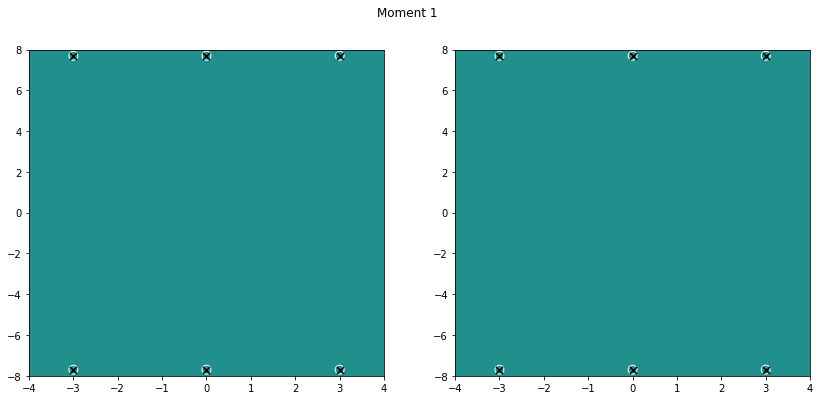

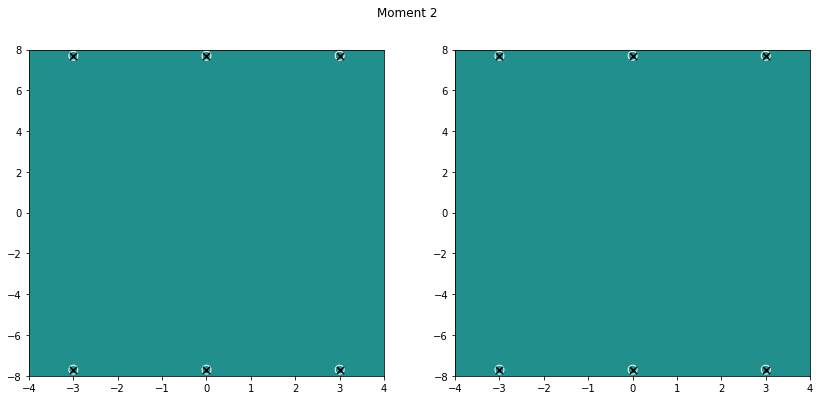

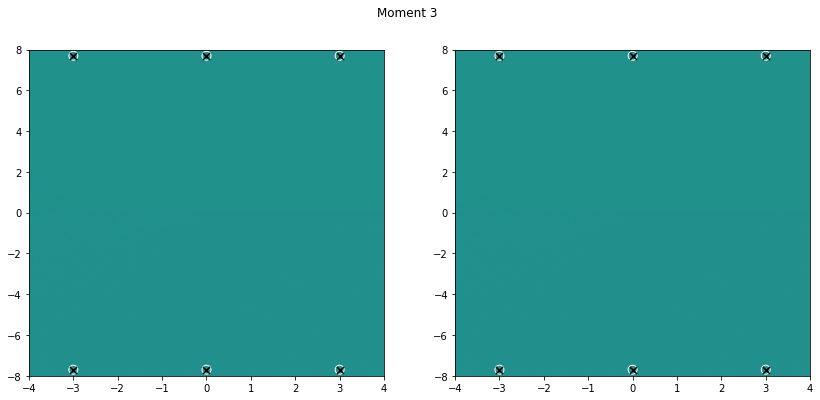

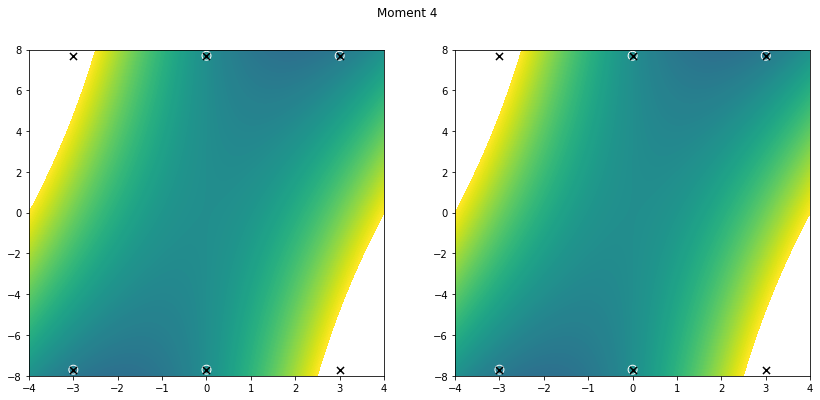

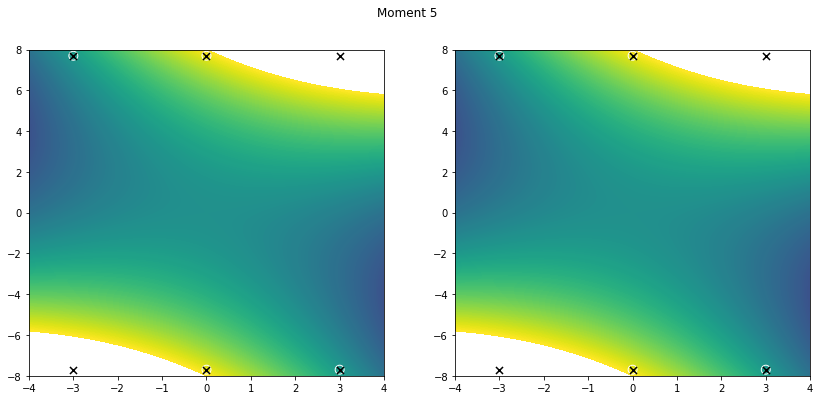

In [9]:
for i in range(5):
    fig, axs = plt.subplots(1,2)
    fig.set_figheight(6)
    fig.set_figwidth(14)
    levels = np.linspace(-1,1,201)
    Y,X = np.meshgrid(y,x)
    for j in range(2):
        Grid1 = MomentGrid(x,y,i, multipole=Multipole[0])
        Grid2 = MomentGrid(x,y,i, multipole=Multipole[1])
        
        Z = (Grid1/max(np.amax(Grid1), -np.amin(Grid1))) - (Grid2/max(np.amax(Grid2), -np.amin(Grid2)))
        contour_filled = axs[j].contourf(X, Y, Z, levels)
        #plt.colorbar(contour_filled)
        axs[j].scatter(trfp.FP6_X, trfp.FP6_Y, s = 80, edgecolors = 'white', facecolors = 'none', alpha = 1)
        axs[j].scatter(trfp.FP6_X, trfp.FP6_Y, s = 50, marker = 'x', color = 'black')
    fig.suptitle("Moment " + str(i+1))
    plt.show()

In [153]:
Multipole = [1,0]
Grid = MomentGrid(x,y,7, multipole=False)

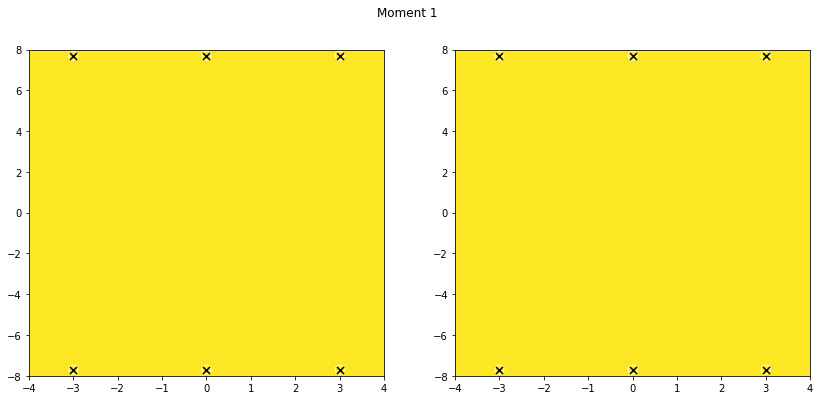

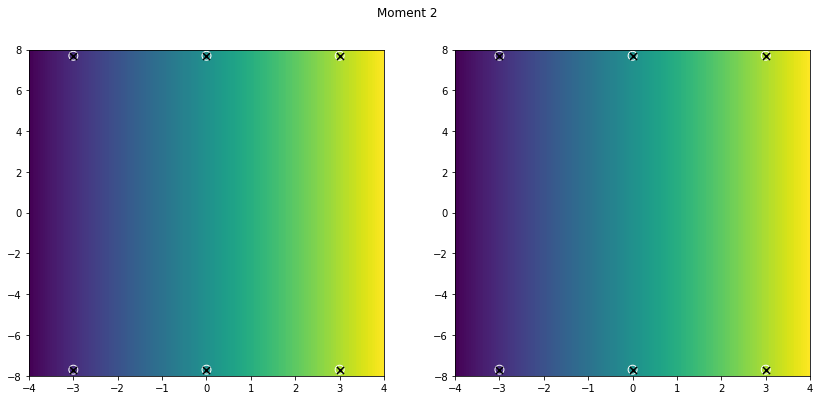

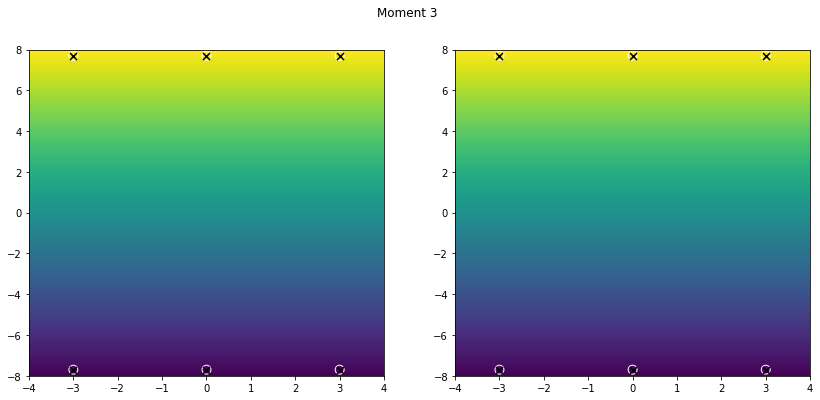

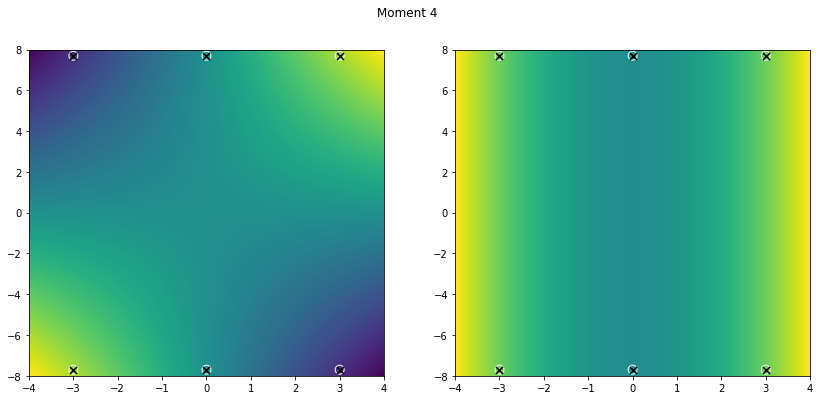

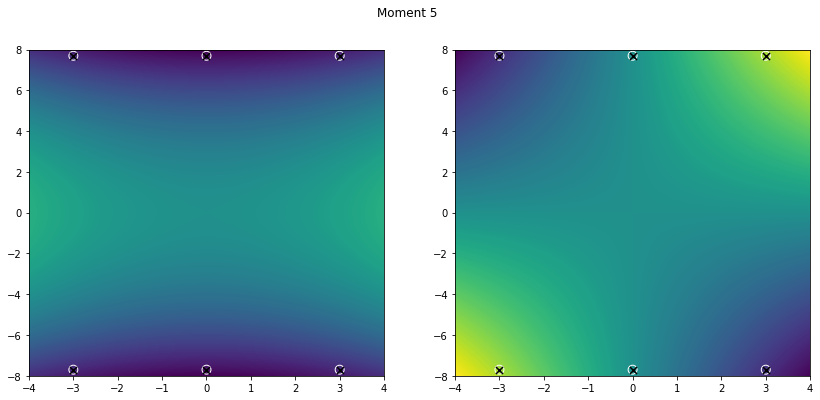

In [165]:
for i in range(5):
    fig, axs = plt.subplots(1,2)
    fig.set_figheight(6)
    fig.set_figwidth(14)
    levels = np.linspace(-1,1,201)
    Y,X = np.meshgrid(y,x)
    for j in range(2):
        Grid = MomentGrid(x,y,i, multipole=Multipole[j])
        Z = Grid/max(np.amax(Grid), -np.amin(Grid))
        contour_filled = axs[j].contourf(X, Y, Z, levels)
        #plt.colorbar(contour_filled)
        axs[j].scatter(trfp.FP6_X, trfp.FP6_Y, s = 80, edgecolors = 'white', facecolors = 'none', alpha = 1)
        axs[j].scatter(trfp.FP6_X, trfp.FP6_Y, s = 50, marker = 'x', color = 'black')
    fig.suptitle("Moment " + str(i+1))
    plt.show()

In [160]:
Grid = MomentGrid(x,y,4)
print(np.amin(Grid))

-3.1604938271604937


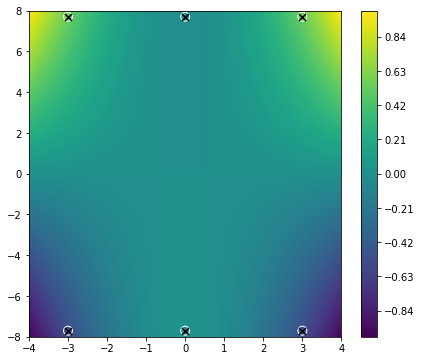

In [151]:
h = 1
fig, axs = plt.subplots(1,2)
fig.set_figheight(6)
fig.set_figwidth(7)

levels = np.linspace(-h,h, int(h*200 +1))
\
Y,X = np.meshgrid(y,x)
Z = Grid/np.amax(Grid)

contour_filled = axs.contourf(X, Y, Z, levels)

plt.colorbar(contour_filled)
axs.scatter(trfp.FP6_X, trfp.FP6_Y, s = 80, edgecolors = 'white', facecolors = 'none', alpha = 1)
axs.scatter(trfp.FP6_X, trfp.FP6_Y, s = 50, marker = 'x', color = 'black')
plt.show()

In [6]:
geom = Geometry(trfp.TR_X, trfp.TR_Y, np.zeros(17)+1)
for i in range(14):
    print(ProbeDrops(geom, tpMomentCap=i+1, fpMomentCap=5)[0])
    print('\n')

[[1.]]
[0.05882353 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353
 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353
 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353]


[[1. 0.]
 [0. 1.]]
[0.05882353 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353
 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353
 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353]


[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[0.05882353 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353
 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353
 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353]


[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[0.05882353 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353
 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353
 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353]


[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
[0.05882353 0

In [38]:
probes = np.zeros(6) + 1
probes[0] = 0
probes[3] = 0
fpGeom = Geometry(trfp.FP6_X, trfp.FP6_Y, probes)
fpTheta = ProbeDrops(fpGeom, fpMomentCap = 4)
#print("Dropped probe 0, [m1,m4] \n")
print(fpTheta)

Dropped probe 0, [m1,m4] 

[[ 0.          0.5         0.          0.          0.5         0.        ]
 [ 0.         -0.75        0.75        0.         -0.75        0.75      ]
 [ 0.          0.29220779  0.          0.         -0.29220779  0.        ]
 [ 0.         -0.21915584  0.21915584  0.          0.21915584 -0.21915584]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]]


In [34]:
probes = np.zeros(6) + 1
#probes[0] = 0
probes[1] = 0
fpGeom = Geometry(trfp.FP6_X, trfp.FP6_Y, probes)
fpTheta = ProbeDrops(fpGeom, fpMomentCap = 5)
print("Dropped probe 0, [m1,m5] \n")
print(fpTheta)

Dropped probe 0, [m1,m5] 

[[ 0.25        0.          0.25        3.04388889 -5.58777778  3.04388889]
 [-0.375       0.          0.375      -0.375       0.          0.375     ]
 [ 0.1461039   0.          0.1461039  -0.1461039   0.         -0.1461039 ]
 [-0.10957792  0.          0.10957792  0.10957792  0.         -0.10957792]
 [ 0.          0.          0.          1.125      -2.25        1.125     ]
 [ 0.          0.          0.          0.          0.          0.        ]]


In [ ]:
print(np.matmul(trfp.J_4_PROBE[:4, :4], trfp.THETA_FP_4))

In [ ]:
print(trfp.J_4_PROBE)
print(trfp.THETA_FP_4)

In [ ]:
print(trfp.THETA_TR)

In [ ]:
J_6_PROBE6x6 = np.array([[1.0, 0.0, 0.0, 0.0, 2.631605, 0.0],
                         [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
                         [0.0, 0.0, 1.0, 0.0, 0.0, -0.339835],
                         [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
                         [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                         [0.0, 0.0, 0.0, 0.0, 0.0, -0.166667]])

J_6_PROBE = np.array([[1.0, 0.0, 0.0, 0.0, 2.631605],
                      [0.0, 1.0, 0.0, 0.0, 0.0],
                      [0.0, 0.0, 1.0, 0.0, 0.0],
                      [0.0, 0.0, 0.0, 1.0, 0.0],
                      [0.0, 0.0, 0.0, 0.0, 1.0]])

J_6_PROBE_OFFSET = np.array([[1.0, 0.222222, 0.0, 0.0, 2.680987],
                             [0.0, 1.0, 0.0, 0.0, 0.444444],
                             [0.0, 0.0, 1.0, 0.444444, 0.0],
                             [0.0, 0.0, 0.0, 1.0, 0.0],
                             [0.0, 0.0, 0.0, 0.0, 1.0]])

J_4_PROBE = np.array([[1.0, 0.0, 0.0, 0.0, 2.927901],
                      [0.0, 1.0, 0.0, 0.0, -0.666667],
                      [0.0, 0.0, 1.0, -0.666667, 0.0],
                      [0.0, 0.0, 0.0, 1.0, 0.0],
                      [0.0, 0.0, 0.0, 0.0, 1.0]])

J_4_PROBE_ST41 = np.array([[1.0, 0.0, 0.0, 0.0, 2.927901],
                           [0.0, 1.0, 0.0, 0.0, 0.0],
                           [0.0, -0.194805, 1.0, 0.0, 0.0],
                           [0.0, 0.0, 0.0, 1.0, -0.194805],
                           [0.0, 0.0, 0.0, 0.0, 1.0]])

J_4_PROBE_ST37_ST39 = np.array([[1.0, 0.0, 0.0, 0.0, 2.927901],
                                [0.0, 1.0, 0.0, 0.0, 0.0], 
                                [0.0, -0.194805, 1.0, 0.0, 0.0], 
                                [0.0, 0.0, 0.0, 1.0, -0.194805], 
                                [0.0, 0.0, 0.0, 0.0, 1.0]])

In [ ]:
THETA_FP_6 = np.array([np.array([1, 1, 1, 1, 1, 1])/6.,  # dipole
                       np.array([1, 0, -1, 1, 0, -1])/-12.*4.5,  # n quad
                       np.array([1, 1, 1, -1, -1, -1])/46.2*4.5,  # s quad
                       np.array([1, 0, -1, -1, 0, 1])/-92.4/2*4.5**2,  # s sext
                       np.array([1, -2, 1, 1, -2, 1])/18./2*4.5**2,  # n sext
                       np.array([1, -2, 1, -1, 2, -1])/-138.6*4.5**3]  # NOT oct, no idea what this is
                     )

THETA_FP_4 = np.array([np.array([1, 0, 1, 0])/2.,  # dipole
                       np.array([1, -1, 1, -1])/-6.*4.5,  # n quad
                       np.array([1, 1, -1, -1])/30.8*4.5,  # s quad
                       np.array([1, -1, -1, 1])/-46.2/2*4.5**2]  # sext
                     )

# four probe stations in the garage (stations 37, 39, 41) have a different arrangement of probes
# STATION 37, 39
# TM, TO, BI, BM
THETA_FP_4_ST37_ST39 = np.array([np.array([1, 0, 0, 1])/2.,  #dipole
                                 np.array([-1, 1, -1, 1])/6.*4.5,  # n quad
                                 np.array([1, 1, -1, -1])/30.8*4.5,  # s quad
                                 np.array([-1, 1, 1, -1])/46.2/2*4.5**2]  # sext?
                               )
# STATION 41
# TO, TM, BI, BM
THETA_FP_4_ST41 = np.array([np.array([0, 1, 0, 1])/2.,  #dipole
                            np.array([1, -1, -1, 1])/6.*4.5,  # n quad
                            np.array([1, 1, -1, -1])/30.8*4.5,  # s quad
                            np.array([1, -1, 1, -1])/46.2/2*4.5**2]  # sext?
                          )

In [ ]:
#Checking what each probe would read given a moment of magnitude 1
_MULTIPOLE_ORDER = [0, 1, 1, 2, 2, 3]
_MULTIPOLE_SKEW = [0, 0, 1, 1, 0, 1]

#_MULTIPOLE_ORDER = [0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 7, 7]
#_MULTIPOLE_SKEW = [0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1]

_MULTS_FP_N = np.array([__multipole(_MULTIPOLE_ORDER[i], _MULTIPOLE_SKEW[i], 1, FP6_X, FP6_Y) for i in range(len(_MULTIPOLE_ORDER) - len(drops))])
_MULTS_FP_N[np.abs(_MULTS_FP_N) < 1.0e-9] = 0
#print(_MULTS_FP_N)

THETA_FPN = np.linalg.pinv(np.transpose(_MULTS_FP_N))
THETA_FPN[np.abs(THETA_FPN) < 1.0e-9] = 0
print(THETA_FPN)
#print(THETA_FP_6)

The above code works for 6 working fp. Below will be testing for 4 probes

In [ ]:
#### For some reason this changes when more multipoles are used. I am assuming it has to do with m6 not bing linearly indep.
_MULTIPOLE_ORDER = [0, 1, 1, 2, 2, 3]
_MULTIPOLE_SKEW = [0, 0, 1, 1, 0, 0]
_MULTS_FP6 = np.array([__multipole(_MULTIPOLE_ORDER[i], _MULTIPOLE_SKEW[i], 1, FP6_X, FP6_Y) for i in range(len(_MULTIPOLE_ORDER))])
_MULTS_FP6[np.abs(_MULTS_FP6) < 1.0e-9] = 0

THETA_FP6 = np.linalg.pinv(np.transpose(_MULTS_FP6))
THETA_FP6[np.abs(THETA_FP6) < 1.0e-9] = 0
print(THETA_FP6)

In [ ]:
######### Below is an attempt to create a station with 4 probes

In [ ]:
PROBES = [0,1,1,0,1,1] #1 means the probe is working properly, 0, it is dropped or does not exist.
drops = np.array([])
for i in range(len(PROBES)):
    if not PROBES[i]:
        drops = np.append(drops, i)
drops = drops.astype(int)


FP6_X_NEW = np.delete(FP6_X, drops)  # now only the x pos of working probes are stored
FP6_Y_NEW = np.delete(FP6_Y, drops)  # same with y pos
PROBES_NEW = np.delete(PROBES, drops)# array of 1s of length of the number of working probes

In [ ]:
_MULTIPOLE_ORDER = [0, 1, 1, 2, 2, 3]
_MULTIPOLE_SKEW = [0, 0, 1, 1, 0, 1]

_MULTS_FP_N = np.array([__multipole(_MULTIPOLE_ORDER[i], _MULTIPOLE_SKEW[i], 1, FP6_X_NEW, FP6_Y_NEW) for i in range(len(_MULTIPOLE_ORDER) - len(drops))])
_MULTS_FP_N[np.abs(_MULTS_FP_N) < 1.0e-9] = 0

INV_MULT = np.linalg.pinv(np.transpose(_MULTS_FP_N))
INV_MULT[np.abs(INV_MULT) < 1.0e-9] = 0

#Add the columns of 0s
inv_mult = np.zeros((len(INV_MULT), len(PROBES)))
j = 0
for i in range(len(PROBES)):
    if PROBES[i] == 1:
        inv_mult[:,i] = INV_MULT[:,j]
        j+=1
#Add rows
for i in range(len(PROBES) - len(PROBES_NEW)):
    inv_mult = np.concatenate((inv_mult, np.zeros((1,len(PROBES)))))

THETA = np.dot(np.linalg.pinv(J_6_PROBE6x6), inv_mult)
THETA[np.abs(THETA) < 1.0e-9] = 0
THETA = THETA[:len(PROBES_NEW)]
T = np.zeros((len(PROBES_NEW),len(PROBES_NEW)))
j = 0
for i in range(len(PROBES)):
    if(np.sum(np.abs(THETA[:,i])))> 1e-8:
        T[:,j] = THETA[:,i]
        j+=1
THETA = T
print("Calculated Theta for 4 fp stattion")
print(THETA)
print("############")
print("Hard Coded theta for 4 fp station")
print(np.array([np.array([1, 0, 1, 0])/2.,  # dipole
                       np.array([1, -1, 1, -1])/-6.*4.5,  # n quad
                       np.array([1, 1, -1, -1])/30.8*4.5,  # s quad
                       np.array([1, -1, -1, 1])/-46.2/2*4.5**2]  # sext
                     )
)

In [ ]:
####### Now trolley

In [ ]:
PROBES = np.zeros(17) + 1 #1 means the probe is working properly, 0, it is dropped or does not exist.
PROBES = PROBES.astype('int')
PROBES[8] = 0
print(PROBES)
drops = np.array([]) #This is meant to be empty, will be filled to know what probes to drop
for i in range(len(PROBES)):
    if not PROBES[i]:
        drops = np.append(drops, i)
drops = drops.astype(int)

X = trfp.TR_X.copy()
Y = trfp.TR_Y.copy()

TR_X_NEW = np.delete(X, drops)  # now only the x pos of working probes are stored
TR_Y_NEW = np.delete(Y, drops)  # same with y pos
PROBES_NEW = np.delete(PROBES, drops)# array of 1s of length of the number of working probes

In [ ]:
_MULTIPOLE_ORDER = [0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 7, 7]
_MULTIPOLE_SKEW = [0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1]
# Skew 14 pole is unmeasurable probes are on nodes.
# 4  is 10 pole, anything above this is unreliable. Uncertainty on cal. coeff. --> prop. uncertainty...
# on cal. becomes too large

if len(drops) == 0:
    _MULTS_TR_N = np.array([__multipole(_MULTIPOLE_ORDER[i], _MULTIPOLE_SKEW[i], 1, TR_X_NEW, TR_Y_NEW) for i in range(len(_MULTIPOLE_ORDER))])

else: #This else must be corrected for trolley drops instead of fp
    _MULTS_TR_N = np.array([__multipole(_MULTIPOLE_ORDER[i], _MULTIPOLE_SKEW[i], 1, TR_X_NEW, TR_Y_NEW) for i in range(len(_MULTIPOLE_ORDER) - len(drops) + 1)])

_MULTS_TR_N[np.abs(_MULTS_TR_N) < 1.0e-9] = 0 


INV_MULT = np.linalg.pinv(np.transpose(_MULTS_TR_N))
INV_MULT[np.abs(INV_MULT) < 1.0e-9] = 0
#Add the columns of 0s
inv_mult = np.zeros((len(INV_MULT), len(PROBES)))
j = 0
for i in range(len(PROBES)):
    if PROBES[i] == 1:
        inv_mult[:,i] = INV_MULT[:,j]
        j+=1
for i in range(len(PROBES) - len(PROBES_NEW)):
    inv_mult = np.concatenate((inv_mult, np.zeros((1,len(PROBES)))))
    
print(inv_mult)